<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Assignment-2:-Predicting-Energy-Consumption" data-toc-modified-id="Assignment-2:-Predicting-Energy-Consumption-1">Assignment 2: Predicting Energy Consumption</a></span></li><li><span><a href="#Question-1" data-toc-modified-id="Question-1-2">Question 1</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-3">Question 2</a></span><ul class="toc-item"><li><span><a href="#Linear-Model" data-toc-modified-id="Linear-Model-3.1">Linear Model</a></span></li><li><span><a href="#Support-Vector-Regression" data-toc-modified-id="Support-Vector-Regression-3.2">Support Vector Regression</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-3.3">Decision Tree</a></span></li></ul></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-4">Question 3</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Error-Metric-Selection" data-toc-modified-id="Error-Metric-Selection-4.0.1">Error Metric Selection</a></span><ul class="toc-item"><li><span><a href="#In-conclusion,-the-model-of-choice-would-be-the-Decision-Tree" data-toc-modified-id="In-conclusion,-the-model-of-choice-would-be-the-Decision-Tree-4.0.1.1">In conclusion, the model of choice would be the <strong>Decision Tree</strong></a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Question-4" data-toc-modified-id="Question-4-5">Question 4</a></span></li></ul></div>

# Practical Data Science
## Assignment 2: Predicting Energy Consumption


In [3]:
import pandas as pd
import io
import requests
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from mlxtend.plotting import plot_decision_regions



%matplotlib inline

## Question 1

In [4]:
#parsing the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
s=requests.get(url).content

In [5]:
data=pd.read_csv(io.StringIO(s.decode('utf-8')))

data['date'] =  pd.to_datetime(data['date'])

In [6]:
#pythoning the field names
data = data.rename(index=str, columns=
              {'lights': 'Lights',
               'T1': 'T_Kitchen',
               'RH_1': 'H_Kitchen',
               'T2': 'T_LivRoom',
               'RH_2': 'H_LivRoom',
               'T3': 'T_Laundry',
               'RH_3': 'H_Laundry',
               'T4': 'T_Office',
               'RH_4': 'H_Office',
               'T5': 'T_WC',
               'RH_5': 'H_WC',
               'T6': 'T_NorthS',
               'RH_6': 'H_NorthS',
               'T7': 'T_Iron',
               'RH_7': 'H_Iron',
               'T8': 'T_Teen',
               'RH_8': 'H_Teen',
               'T9': 'T_Parent',
               'RH_9': 'H_Parent',
               'RH_out': 'H_out'})

In [7]:
#examine NAs
sum(data.isna().sum())



0

In [8]:
#feature engineering

data['WeekDay'] = data['date'].dt.weekday


data['Hour'] = data['date'].dt.hour
data['Minute'] = data['date'].dt.minute

#drop the unnecessary fields
dtemp = data.drop(['T_out', 'H_out', 'T_NorthS', 'H_NorthS'], axis =1)

#combine all the temp and humidity fields
#chose the median which is less sensitive to outliers
data['Temp'] = dtemp[dtemp.filter(like='T_').columns].median(axis=1)
data['Humid'] = dtemp[dtemp.filter(like='H_').columns].median(axis=1)

#combine the two energy consumption fields
data['Energy'] = data[['Appliances', 'Lights']].sum(axis=1)

In [9]:
#drops old fields
data = data[['Energy','WeekDay','Hour','Minute', 'Temp','Humid']]

In [10]:
#Aggregations for Temperature and Humidity

dmerge1 = data[['Temp', 'Humid']].groupby(data['WeekDay']).mean().reset_index().add_suffix('_Day_Mean')
dmerge2 = data[['Temp', 'Humid']].groupby(data['Hour']).mean().reset_index().add_suffix('_Hour_Mean')
dmerge3 = data[['Temp', 'Humid']].groupby(data['Minute']).mean().reset_index().add_suffix('_Mint_Mean')

dmerge4 = data[['Temp', 'Humid']].groupby(data['WeekDay']).max().reset_index().add_suffix('_Day_Max')
dmerge5 = data[['Temp', 'Humid']].groupby(data['Hour']).max().reset_index().add_suffix('_Hour_Max')
dmerge6 = data[['Temp', 'Humid']].groupby(data['Minute']).max().reset_index().add_suffix('_Mint_Max')


In [11]:
#merge the above datasets
data = data.merge(dmerge1, left_on='WeekDay', right_on='WeekDay_Day_Mean', how='left')
data = data.merge(dmerge4, left_on='WeekDay', right_on='WeekDay_Day_Max', how='left')
data = data.merge(dmerge2, left_on='Hour', right_on='Hour_Hour_Mean', how='left')
data = data.merge(dmerge5, left_on='Hour', right_on='Hour_Hour_Max', how='left')
data = data.merge(dmerge3, left_on='Minute', right_on='Minute_Mint_Mean', how='left')
data = data.merge(dmerge6, left_on='Minute', right_on='Minute_Mint_Max', how='left')


In [12]:
#drop the uesless fields
data= data.drop(['WeekDay_Day_Mean','WeekDay_Day_Max','Minute_Mint_Mean','Minute_Mint_Max', 'Hour_Hour_Mean','Hour_Hour_Max'], axis=1)

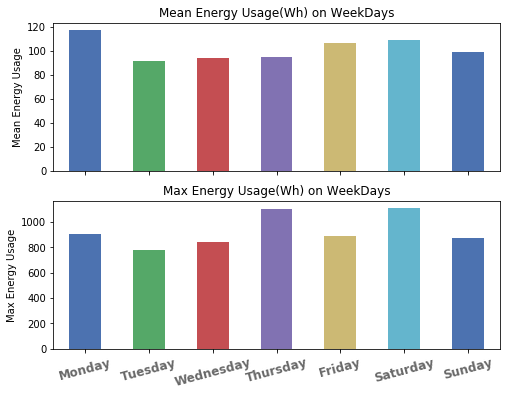

In [13]:
a, ax1 = plt.subplots(nrows=2, ncols=1, figsize= (8,6), sharex=True)
plt.style.use('seaborn-deep')

Days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']

data['Energy'].groupby(data['WeekDay']).mean().plot(kind = 'bar', ax=ax1[0]).set(ylabel='Mean Energy Usage', title = 'Mean Energy Usage(Wh) on WeekDays')
data['Energy'].groupby(data['WeekDay']).max().plot(kind = 'bar', ax=ax1[1]).set(ylabel='Max Energy Usage', title = 'Max Energy Usage(Wh) on WeekDays')

plt.xlabel('')
plt.xticks(np.arange(len(Days)), Days, color='dimgrey', rotation=15, fontweight='bold', fontsize='12', horizontalalignment='center')
plt.show()


[Text(0, 0.5, 'Max Energy'), Text(0.5, 1.0, 'Max Energy per Hour')]

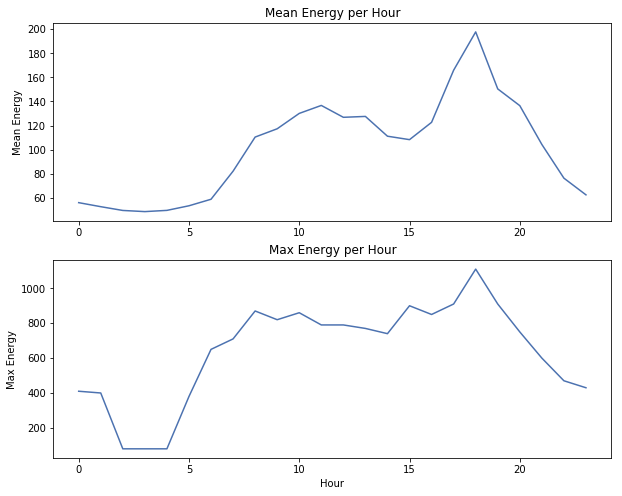

In [14]:
b, ax2 = plt.subplots(nrows=2, figsize= (10,8))
plt.style.use('seaborn-deep')



data.groupby(data['Hour']).mean()['Energy'].plot(kind = 'line', ax=ax2[0]).set(xlabel = '',ylabel='Mean Energy', title = 'Mean Energy per Hour')
data.groupby(data['Hour']).max()['Energy'].plot(kind = 'line', ax=ax2[1]).set(ylabel='Max Energy', title = 'Max Energy per Hour')



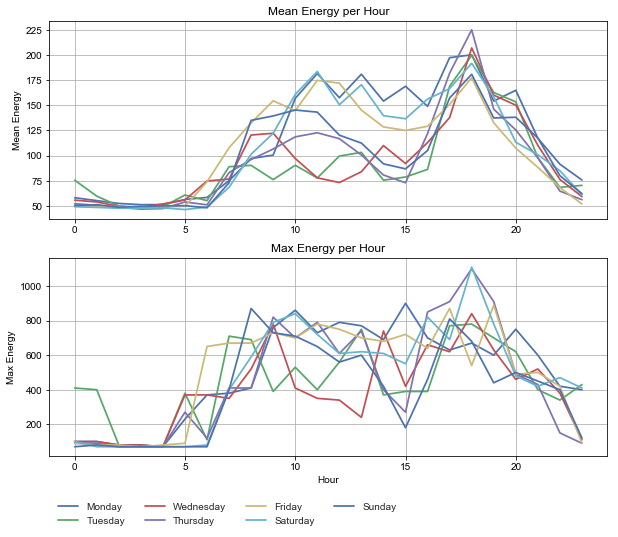

In [15]:
c, ax3 = plt.subplots(nrows=2, figsize= (10,8))
plt.style.use('seaborn')



data.groupby(['Hour','WeekDay'])['Energy'].mean().unstack().plot(kind = 'line', ax=ax3[0], legend = False).set(xlabel = '',ylabel='Mean Energy', title = 'Mean Energy per Hour')
data.groupby(['Hour','WeekDay']).max()['Energy'].unstack().plot(kind = 'line', ax=ax3[1]).set(ylabel='Max Energy', title = 'Max Energy per Hour')

plt.legend(Days,bbox_to_anchor=(0., -0.4, 1., 1), loc=3, ncol=4,)

Intuitively, we would assume that during weekdays, people consume less energy than during the weekend. However from the graphs above, it is shown that the max mean energy consumption occurs on Mondays with weekend following suit.

Furthermore, it would be logical to assume that throughout the day, people consume more energy from noon to dusk on weekdays and a more uniform consumption on weekends.
However, there is an obvious peak in energy consumption around noon, everyday.



-----------------------------------

## Question 2

-----------------------------------

### Linear Model

In [16]:
#normalize data
data.iloc[:,1:] = StandardScaler().fit_transform(data.iloc[:,1:])

X = data.drop(['Energy'], axis =1)
Y = data.Energy

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10) 


C:\Users\akaplanis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\akaplanis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [17]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
coeff_df = pd.DataFrame(list(zip(X.columns, lin_model.coef_)), columns = ['Features', 'EstimatedCoeffs'])

In [19]:
Y_pred = lin_model.predict(X_test)  

In [20]:
df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})  
 

As en error metric to test the validity of the model I would use the R squared adjusted.

As seen in the summary below,when using all the available features its value is rather low, at 0,167.
This means that it could get better if some of the features were excluded.

In [21]:
lm = ols('Energy ~ WeekDay+ Hour+ Minute+ Temp+Humid+Temp_Day_Mean+Humid_Day_Mean+Temp_Day_Max+Humid_Day_Max+Temp_Hour_Mean+Humid_Hour_Mean+Temp_Hour_Max+Humid_Hour_Max+Temp_Mint_Mean+Humid_Mint_Mean+Temp_Mint_Max+Humid_Mint_Max',data=data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     186.1
Date:                Sun, 13 Jan 2019   Prob (F-statistic):               0.00
Time:                        20:39:57   Log-Likelihood:            -1.1826e+05
No. Observations:               19735   AIC:                         2.366e+05
Df Residuals:                   19717   BIC:                         2.367e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         101.4968      0.690    147.089      0.000     100.144     102.849
WeekDay           -16.3483      1.834     -8.913      0.000     -19.944     -12.753
Hour               11.7541      1.092     10.768      0.000       9.615      13.894
Minute              0.9680      2.123      0.456      0.648      -3.193       5.129
Temp                1.8534      0.702      2.639      0.008       0.477       3.230
Humid               5.7875      0.705      8.208      0.000       4.405       7.170
Temp_Day_Mean     -15.9231      1.605     -9.921      0.000     -19.069     -12.777
Humid_Day_Mean     -2.9564      1.067     -2.771      0.006      -5.048      -0.865
Temp_Day_Max       -4.8626      1.043     -4.663      0.000      -6.907      -2.819
Humid_Day_Max      13.8327      1.523      9.085      0.000      10.848      16.817
Temp_Hour_Mean     11.3896      2.601      4.379      0.000       6.292      16.488
Humid_Hour_Mean    17.5747      3.728      4.715      0.000      10.268      24.881
Temp_Hour_Max      17.0849      2.495      6.847      0.000      12.194      21.976
Humid_Hour_Max     29.7875      1.312     22.703      0.000      27.216      32.359
Temp_Mint_Mean      1.6065      2.688      0.598      0.550      -3.663       6.876
Humid_Mint_Mean    -0.9404      3.888     -0.242      0.809      -8.561       6.680
Temp_Mint_Max      -0.2996      3.237     -0.093      0.926      -6.644       6.045
Humid_Mint_Max     -0.0914      1.467     -0.062      0.950      -2.967       2.784
==============================================================================
Omnibus:                    13477.184   Durbin-Watson:                   0.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           186175.995
Skew:                           3.193   Prob(JB):                         0.00
Kurtosis:                      16.625   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
lm_adj =ols('Energy ~ WeekDay+ Hour+ Temp+Humid+Temp_Day_Mean+Humid_Day_Mean+Temp_Day_Max+Humid_Day_Max+Temp_Hour_Mean+Humid_Hour_Mean+Temp_Hour_Max+Humid_Hour_Max',data=data).fit()

lm_adj.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Energy   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     263.2
Date:                Sun, 13 Jan 2019   Prob (F-statistic):               0.00
Time:                        20:39:57   Log-Likelihood:            -1.1827e+05
No. Observations:               19735   AIC:                         2.366e+05
Df Residuals:                   19722   BIC:                         2.367e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         101.4968      0.690    147.087      0.000     100.144     102.849
WeekDay           -16.3484      1.834     -8.913      0.000     -19.944     -12.753
Hour               11.7541      1.092     10.768      0.000       9.614      13.894
Temp                1.8541      0.702      2.640      0.008       0.477       3.231
Humid               5.7883      0.705      8.209      0.000       4.406       7.170
Temp_Day_Mean     -15.9231      1.605     -9.920      0.000     -19.069     -12.777
Humid_Day_Mean     -2.9566      1.067     -2.771      0.006      -5.048      -0.865
Temp_Day_Max       -4.8628      1.043     -4.663      0.000      -6.907      -2.819
Humid_Day_Max      13.8327      1.523      9.085      0.000      10.848      16.817
Temp_Hour_Mean     11.3894      2.601      4.379      0.000       6.291      16.487
Humid_Hour_Mean    17.5743      3.728      4.714      0.000      10.268      24.881
Temp_Hour_Max      17.0847      2.495      6.846      0.000      12.193      21.976
Humid_Hour_Max     29.7874      1.312     22.703      0.000      27.216      32.359
==============================================================================
Omnibus:                    13484.532   Durbin-Watson:                   0.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           186526.497
Skew:                           3.195   Prob(JB):                         0.00
Kurtosis:                      16.638   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Despite, dumping the unnecessary columns, there was no change for the better in R adjusted square. As a result the model is still not fitting for the current task.

-------------------------------

### Support Vector Regression

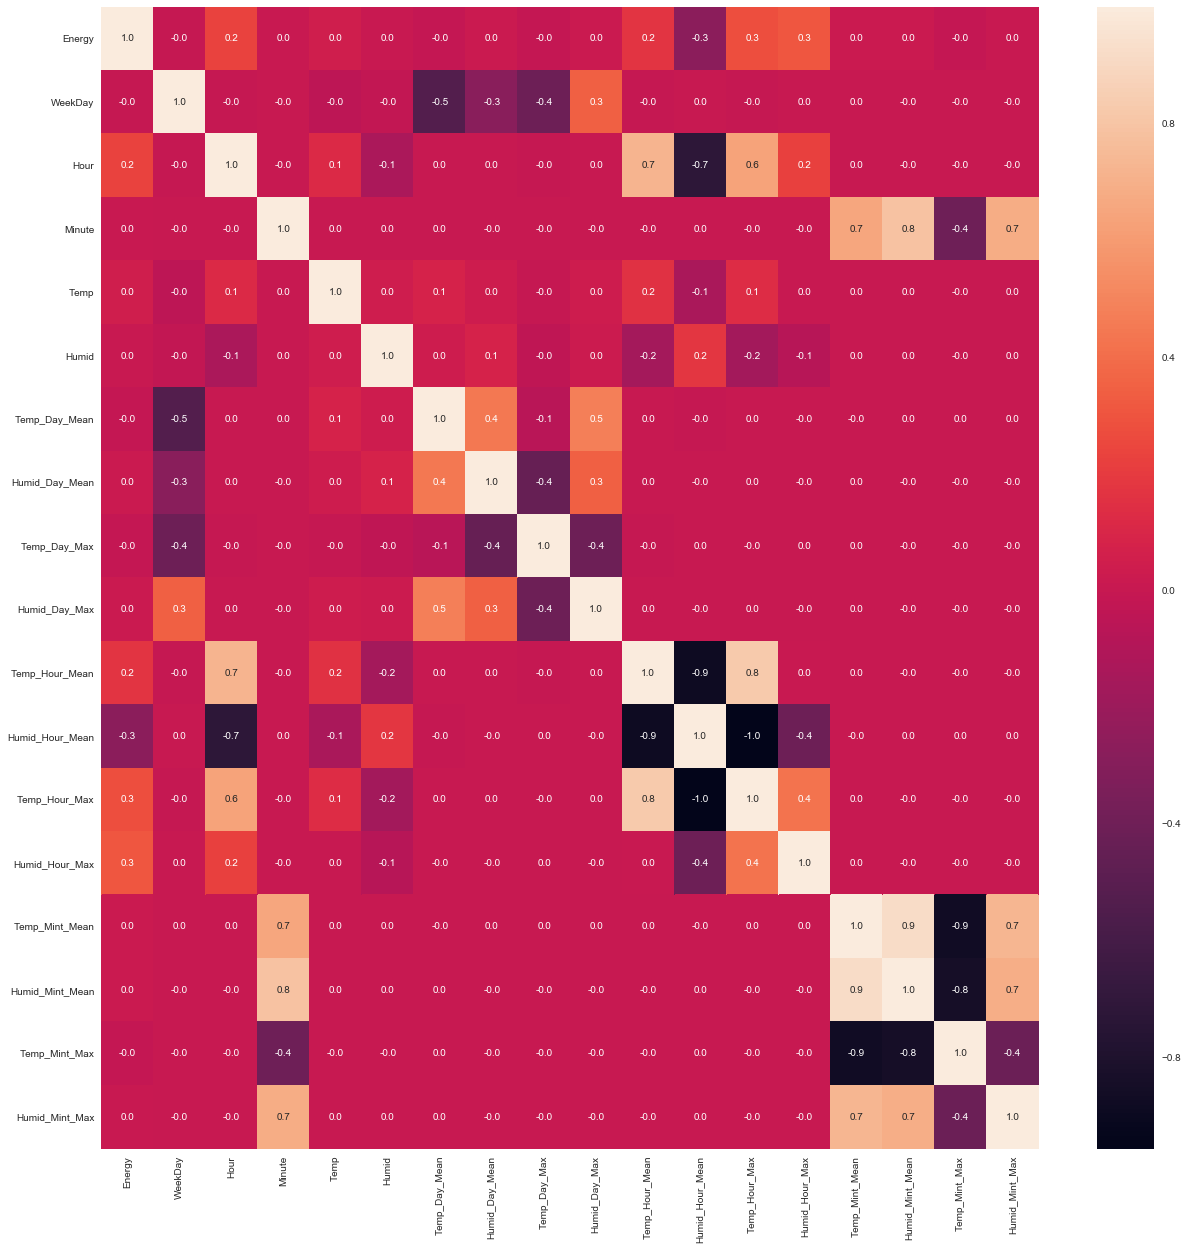

In [23]:
f= plt.subplots(figsize=(21,21))
sn.heatmap(data.corr(),annot=True,fmt='.1f',color='green')



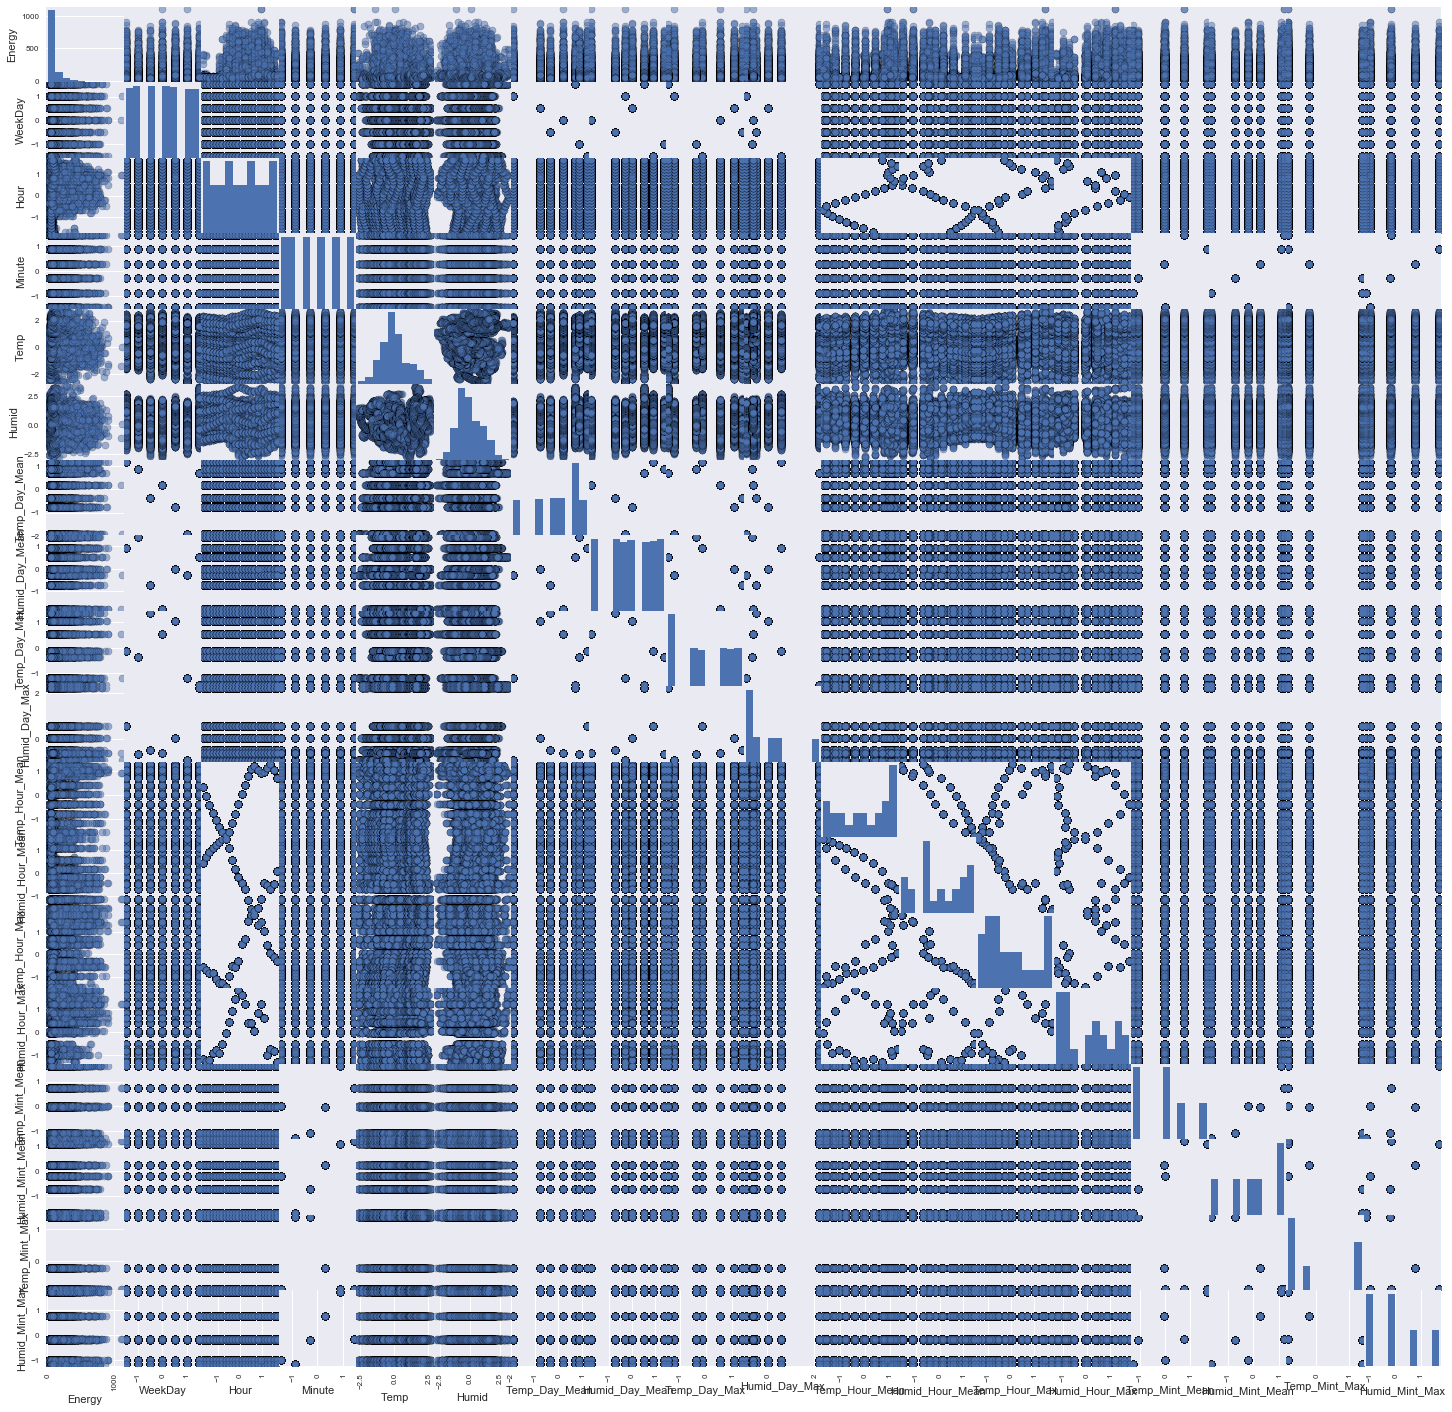

In [24]:
pd.plotting.scatter_matrix(data.iloc[0:,:],alpha=0.5,figsize=[25,25],diagonal='hist',s=200,marker='.',edgecolor='black')
plt.show()

#the multicorrel plot is inconclusive about the data,  so I will only use the fields with non-zero correlation

In [25]:
svr_model = svm.SVR()


In [26]:
svr_model.fit(X_train, Y_train) 

C:\Users\akaplanis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

### Decision Tree

In [27]:
rf_model = RandomForestClassifier(min_samples_split=20, random_state=10)

In [28]:
rf_model.fit(X_train, Y_train)

C:\Users\akaplanis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

## Question 3

In [29]:
kfold = model_selection.KFold(n_splits=5)
MAE = 'neg_mean_absolute_error'
MSE = 'neg_mean_squared_error'
R2 = 'r2'

LR_MAE = model_selection.cross_val_score(lin_model, X_train, Y_train, cv=kfold,scoring = MAE)
LR_MSE = model_selection.cross_val_score(lin_model, X_train, Y_train, cv=kfold,scoring = MSE)
LR_R2 = model_selection.cross_val_score(lin_model, X_train, Y_train, cv=kfold,scoring = R2)

SVR_MAE = model_selection.cross_val_score(svr_model, X_train, Y_train, cv=kfold,scoring = MAE)
SVR_MSE = model_selection.cross_val_score(svr_model, X_train, Y_train, cv=kfold,scoring = MSE)
SVR_R2 = model_selection.cross_val_score(svr_model, X_train, Y_train, cv=kfold,scoring = R2)

RF_MAE = model_selection.cross_val_score(rf_model, X_train, Y_train, cv=kfold,scoring = MAE)
RF_MSE = model_selection.cross_val_score(rf_model, X_train, Y_train, cv=kfold,scoring = MSE)
RF_R2 = model_selection.cross_val_score(rf_model, X_train, Y_train, cv=kfold,scoring = R2)


C:\Users\akaplanis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\akaplanis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\akaplanis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarn

In [30]:
print('1. MAE for the Linear Model is:\n',LR_MAE.mean(),LR_MAE.std(),'\n2. MAE for the SVR is:\n',SVR_MAE.mean(),SVR_MAE.std()
      ,'\n3. MAE for the Random Forest is:\n',RF_MAE.mean(),RF_MAE.std())

1. MAE for the Linear Model is:
 -55.55549679509697 1.268171611229901 
2. MAE for the SVR is:
 -46.11038209998692 1.4613461861969663 
3. MAE for the Random Forest is:
 -44.24706057469925 1.3691072277329144


In [31]:
print('1. MSE for the Linear Model is:\n',LR_MSE.mean(),LR_MSE.std(),'\n2. MSE for the SVR is:\n',SVR_MSE.mean(),SVR_MSE.std()
      ,'\n3. MSE for the Random Forest is:\n',RF_MSE.mean(),RF_MSE.std())

1. MSE for the Linear Model is:
 -9428.922592699953 634.8998832107686 
2. MSE for the SVR is:
 -10601.379995362686 790.4269677518297 
3. MSE for the Random Forest is:
 -10931.147356327696 827.2293535893849


In [32]:
print('1. R2 for the Linear Model is:\n',LR_R2.mean(),LR_R2.std(),'\n2. R2 for the SVR is:\n',SVR_R2.mean(),SVR_R2.std()
      ,'\n3. R2 for the Random Forest is:\n',RF_R2.mean(),RF_R2.std())

1. R2 for the Linear Model is:
 0.13579200423134336 0.005623559319315177 
2. R2 for the SVR is:
 0.02882092625153392 0.010440152329429313 
3. R2 for the Random Forest is:
 -0.0013524432774003393 0.011075676875325794


In [33]:
if (LR_MAE.mean() > SVR_MAE.mean() and LR_MAE.mean() > RF_MAE.mean()):
    print('MAE of LR is better')
elif (RF_MAE.mean() > SVR_MAE.mean() and RF_MAE.mean() > LR_MAE.mean()):
    print('MAE of RF is better')
elif (SVR_MAE.mean() > LR_MAE.mean() and SVR_MAE.mean() > RF_MAE.mean()):
    print('MAE of SVR is better')
    

MAE of RF is better


In [34]:
if (LR_MSE.mean() > SVR_MSE.mean() and LR_MSE.mean() > RF_MSE.mean()):
    print('MSE of LR is better')
elif (RF_MSE.mean() > SVR_MSE.mean() and RF_MSE.mean() > LR_MSE.mean()):
    print('MSE of RF is better')
elif (SVR_MSE.mean() > LR_MSE.mean() and SVR_MSE.mean() > RF_MSE.mean()):
    print('MSE of SVR is better')

MSE of LR is better


In [35]:
if (LR_R2.mean() > SVR_R2.mean() and LR_R2.mean() > RF_R2.mean()):
    print('R2 of LR is better')
elif (RF_R2.mean() > SVR_R2.mean() and RF_R2.mean() > LR_R2.mean()):
    print('R2 of RF is better')
elif (SVR_R2.mean() > LR_R2.mean() and SVR_R2.mean() > RF_R2.mean()):
    print('R2 of SVR is better')

R2 of LR is better


#### Error Metric Selection

Out of the 3 error metrics I would prefer to use, in this certain scenario, the MAE.

R-squared is a particularly good metric between linear models. However its dependency on σ^2 makes it unreliable when compared with other types of models. High σ^2 will drive it to zero even if the model is good.

Mean Squared Error is the average of squared differences between prediction and actual observation. It is a popular metricand it could be used in this scenario but by its definition it is obvious that it can be greatly affected by outliers. 
Since outliers could be of value in this dataset, I have not had them treated.

Mean Absolute Error measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s calculated as the average of the absolute differences between prediction and actual observation where all individual differences have equal weight. Given MAEs definition, it is obvious that it is not affected by outliers as much as MSE making it the best choice.

##### In conclusion, the model of choice would be the __Decision Tree__

## Question 4

In [36]:
params_grid = {"n_estimators":[int(x) for x in np.arange(start = 100, stop = 501, step = 100)],
               "max_depth": [int(x) for x in np.arange(start = 5, stop = 10)] + [None], 
               "max_features": ["sqrt", "log2"],
               "bootstrap": [True, False]
              }

In [37]:
rf_model_gridsearchcv = GridSearchCV(estimator = rf_model, 
                                     param_grid = params_grid, 
                                     cv = kfold, 
                                     refit = True, 
                                     verbose = 2, 
                                     n_jobs = -1)

In [38]:
rf_model_gridsearchcv.fit(X_train, Y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 47.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 6, 7, 8, 9, None], 'max_features': ['sqrt', 'log2'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [41]:
rf_model_gridsearchcv.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'n_estimators': 200}